# Land topography data

Data is available on [EUDEM](https://land.copernicus.eu/imagery-in-situ/eu-dem/eu-dem-v1.1)

In [3]:
import os
import fsspec
from glob import glob

import xarray as xr
import pandas as pd
import numpy as np

## 1. Get the right coordinates

In [4]:
repo = "germany_co.zarr"
mapper = fsspec.get_mapper(
    "s3://public-sti-storage/" + repo, 
    key= "2b19ac88b45e46c8822b276cb91e9ce0", 
    secret= "634f4c112a72489d8560c4bd74a20aca", 
    client_kwargs=dict(endpoint_url= "https://s3.waw2-1.cloudferro.com")
)

co_ds = xr.open_zarr(mapper)
co_ds

<xarray.Dataset>
Dimensions:    (time: 25824, level: 1, latitude: 78, longitude: 91)
Coordinates:
  * latitude   (latitude) float32 55.05 54.95 54.85 54.75 ... 47.55 47.45 47.35
  * longitude  (longitude) float64 5.95 6.05 6.15 6.25 ... 14.75 14.85 14.95
  * time       (time) datetime64[ns] 2019-01-21 ... 2021-12-31T23:00:00
Dimensions without coordinates: level
Data variables:
    co_conc    (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 1, 78, 91), meta=np.ndarray>

In [6]:
# Get dimensions
nb_lat = co_ds.dims['latitude']
nb_lon = co_ds.dims['longitude']
min_lon = co_ds.coords['longitude'].values[0]
min_lat = co_ds.coords['latitude'].values[-1]
max_lon = co_ds.coords['longitude'].values[-1]
max_lat = co_ds.coords['latitude'].values[0]

In [7]:
target_lon_array = np.linspace(min_lon,max_lon,10*len(co_ds.coords['longitude']))
target_lon = xr.DataArray(target_lon_array, dims=("longitude"), coords={"longitude": target_lon_array})
target_lon.attrs["standard_name"] = "longitude"
target_lon.attrs["long_name"] = "longitude"
target_lon.attrs["units"] = "degrees_east"

target_lat_array = np.linspace(min_lat,max_lat,10*len(co_ds.coords['latitude']))
target_lat = xr.DataArray(target_lat_array, dims=("latitude"), coords={"latitude": target_lat_array})
target_lat.attrs["standard_name"] = "latitude"
target_lat.attrs["long_name"] = "latitude"
target_lat.attrs["units"] = "degrees_north"

## 2. EUDEM data

In [23]:
from osgeo import gdal

tif_path = "../../data/topography/eu_dem_v11_E40N30/eu_dem_v11_E40N30.TIF"
input_raster = gdal.Open(tif_path)

output_raster = "topo_1.TIF"
warp = gdal.Warp(
    output_raster, 
    input_raster,
    format="GTiff",
    dstSRS='EPSG:4326',
    options=["COMPRESS=LZW", "TILED=YES"]
)
warp = None # Closes the files

In [39]:
tif_path_2 = "../../data/topography/eu_dem_v11_E40N20/eu_dem_v11_E40N20.TIF"
input_raster_2 = gdal.Open(tif_path_2)

output_raster_2 = "topo_2.TIF"
warp = gdal.Warp(
    output_raster_2, 
    input_raster_2,
    format="GTiff",
    dstSRS='EPSG:4326',
    options=["COMPRESS=LZW", "TILED=YES"]
)
warp = None # Closes the files

In [40]:
ds_1 = xr.open_rasterio("topo_1.TIF")
ds_1 = ds_1.to_dataset(name="topo")
ds_1 = ds_1.rename({"y":"latitude", "x":"longitude"})
ds_1 = ds_1.sel(latitude=slice(max_lat, min_lat), longitude=slice(min_lon, max_lon))
ds_1

C:\Users\Camille\AppData\Local\Temp\ipykernel_1252\1493607968.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds_1 = xr.open_rasterio("topo_1.TIF")


<xarray.Dataset>
Dimensions:    (band: 1, latitude: 17084, longitude: 28841)
Coordinates:
  * band       (band) int32 1
  * latitude   (latitude) float64 55.05 55.05 55.05 55.05 ... 49.72 49.72 49.72
  * longitude  (longitude) float64 5.95 5.951 5.951 5.951 ... 14.95 14.95 14.95
Data variables:
    topo       (band, latitude, longitude) float32 ...

In [41]:
# Adapt to datacube
topo_ds = ds_1.chunk(chunks={"latitude":100, "longitude":100})
topo_interp = topo_ds.chunk().interp({'longitude':target_lon, 'latitude':target_lat},  method = 'linear')
topo_interp

<xarray.Dataset>
Dimensions:    (band: 1, latitude: 780, longitude: 910)
Coordinates:
  * band       (band) int32 1
  * longitude  (longitude) float64 5.95 5.96 5.97 5.98 ... 14.93 14.94 14.95
  * latitude   (latitude) float64 47.35 47.36 47.37 47.38 ... 55.03 55.04 55.05
Data variables:
    topo       (band, latitude, longitude) float32 dask.array<chunksize=(1, 780, 910), meta=np.ndarray>

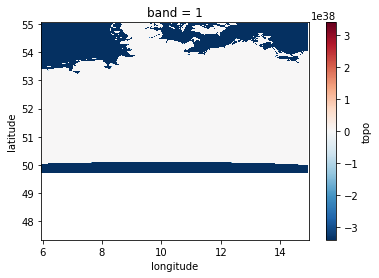

In [43]:
topo_interp["topo"].plot()

## 3. NOAA data

Grid of Earth's surface depicting the bedrock underneath the ice sheets. (1-minute resolution)

In [47]:
topo_ds = xr.open_rasterio("../../data/topography/exportImage.tiff")
topo_ds = topo_ds.to_dataset(name="topo")
topo_ds = topo_ds.rename({"y":"latitude", "x":"longitude"})
topo_ds = topo_ds.drop("band")
topo_ds

C:\Users\Camille\AppData\Local\Temp\ipykernel_1252\2456786819.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  topo_ds = xr.open_rasterio("../../data/topography/exportImage.tiff")


<xarray.Dataset>
Dimensions:    (latitude: 467, longitude: 550, band: 1)
Coordinates:
  * latitude   (latitude) float64 55.05 55.03 55.02 55.0 ... 47.32 47.3 47.28
  * longitude  (longitude) float64 5.883 5.9 5.917 5.933 ... 15.0 15.02 15.03
Dimensions without coordinates: band
Data variables:
    topo       (band, latitude, longitude) int16 ...

In [48]:
topo_interp = topo_ds.chunk().interp({'longitude':target_lon, 'latitude':target_lat},  method = 'linear')
topo_interp

<xarray.Dataset>
Dimensions:    (band: 1, latitude: 780, longitude: 910)
Coordinates:
  * longitude  (longitude) float64 5.95 5.96 5.97 5.98 ... 14.93 14.94 14.95
  * latitude   (latitude) float64 47.35 47.36 47.37 47.38 ... 55.03 55.04 55.05
Dimensions without coordinates: band
Data variables:
    topo       (band, latitude, longitude) float64 dask.array<chunksize=(1, 780, 910), meta=np.ndarray>

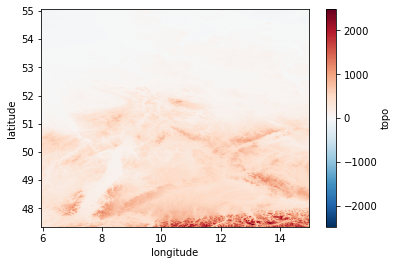

In [51]:
topo_interp["topo"].plot()

## 4. Get dataframe

In [52]:
icos_df = pd.read_csv("../../data/icos_stations.csv")
icos_df.drop("Unnamed: 0", axis=1, inplace=True)
icos_df

name  latitude  longitude
0            Gartow   53.0657    11.4429
1         Helgoland   54.1804     7.8833
2  Hohenpeissenberg   47.8011    11.0246
3         Karlsruhe   49.0915     8.4249
4        Lindenberg   52.1663    14.1226
5        Ochsenkopf   50.0300    11.8083
6       Steinkimmen   53.0431     8.4588
7          Torfhaus   51.8088    10.5350

In [54]:
dfs = []
for station_id in range(len(icos_df)) :
    lat = icos_df.iloc[station_id].latitude
    lon = icos_df.iloc[station_id].longitude
    name = icos_df.iloc[station_id]["name"]
    df = topo_interp.sel(latitude=lat, longitude=lon, method="nearest").to_dataframe()
    df["name"] = [name]
    dfs.append(df)

In [55]:
topo_df = pd.concat(dfs)
topo_df = topo_df.reset_index().drop("band", axis=1)
topo_df

topo  longitude   latitude              name
0   41.999287  11.445049  53.063221            Gartow
1    0.422075   7.880693  54.180166         Helgoland
2  825.331134  11.029208  47.804684  Hohenpeissenberg
3  117.884084   8.425247  49.089665         Karlsruhe
4   68.164456  14.118317  52.163735        Lindenberg
5  875.497474  11.811386  50.028689        Ochsenkopf
6   29.748489   8.454950  53.043452       Steinkimmen
7  736.864986  10.534158  51.807894          Torfhaus

In [56]:
topo_df.to_csv("topo_df.csv")